# 数值稳定性

### 核心原理

神经网络的梯度 = 一堆矩阵连乘  
网络有d层：  
梯度 = ∂L/∂h_d × ∂h_d/∂h_(d-1) × ... × ∂h_(t+1)/∂h_t × ∂h_t/∂w_t  
(d-t) 个矩阵相乘

问题就出在这里：你要把很多矩阵乘在一起  

比如：  

- 1.5 × 1.5 × 1.5 × ... （100次）= 4 × 10^17 → **爆炸**  
- 0.8 × 0.8 × 0.8 × ... （100次）= 2 × 10^-10 → **消失**

## 二、梯度爆炸与梯度消失详解

### 梯度爆炸 —— 数越乘越大

**什么时候会发生？**  
当每层梯度的值 > 1 时，层数一多，连乘就会导致数值急剧增大，最终引发梯度爆炸。

**以 ReLU 激活函数为例：**  

- ReLU 的导数 = **1**（输入 > 0 时）或 **0**（输入 ≤ 0 时）  
- 反向传播中的梯度 ≈ $ W_1 \times W_2 \times W_3 \times \cdots $ 的部分元素相乘  
- 如果权重矩阵中的值普遍略大于 1 → 连乘后结果呈指数级增长 → **爆炸**

**会带来什么问题？**  

- **问题1：数值变成 inf（无穷大）**  
  → 尤其在使用 **16位浮点数**（FP16）时，数值范围仅为 -65504 到 +65504  
  → 一旦超出该范围，数值变为 `inf`，程序直接崩溃  

- **问题2：学习率极难调节**  
  → 学习率稍大 → 参数更新幅度过大 → 梯度进一步放大 → 引发爆炸  
  → 学习率过小 → 参数几乎不更新 → 训练停滞  
  → 只有非常狭窄的学习率区间可用，调参极其困难

### 梯度消失 —— 数越乘越小

**什么时候会发生？**  
当每层梯度的值 < 1 时，随着网络层数增加，多个小于1的数连续相乘，结果趋近于零，造成梯度消失。

**以 Sigmoid 激活函数为例：**  

- Sigmoid 函数：$ \sigma(x) = \frac{1}{1 + e^{-x}} $  
- 其导数：$ \sigma'(x) = \sigma(x)(1 - \sigma(x)) $

| 特性                     | 说明          |
| ------------------------ | ------------- |
| **Sigmoid 导数的最大值** | **只有 0.25** |
| **输入稍大（如 > 4）时** | 导数接近 0    |

因此，每一层的梯度都小于 0.25，经过多层连乘：
$$
0.25 \times 0.25 \times 0.25 \times \cdots \text{（100次）} \approx 0
$$

**会带来什么问题？**  

- **底层（靠近输入的层）根本学不动！**  
  反向传播是从输出层向输入层传递梯度的过程：

| 层级位置         | 梯度状态       | 学习能力     |
| ---------------- | -------------- | ------------ |
| 顶层（靠近输出） | 梯度正常 ✅     | 正常更新参数 |
| 中间层           | 梯度开始变小 ⚠️ | 更新缓慢     |
| 底层（靠近输入） | 梯度 ≈ 0 ❌     | 完全无法学习 |

**结果：**  
你以为你搭建了一个100层的深度神经网络，  
但实际上只有顶部几层在学习，  
底层参数几乎不变，等同于一个浅层网络 —— **白搭了！**

### 一张图总结

| 梯度爆炸                              | 梯度消失                                 |
| ------------------------------------- | ---------------------------------------- |
| 原因：每层梯度 > 1，连乘后 → 越乘越大 | 原因：每层梯度 < 1，连乘后 → 越乘越小    |
| 激活函数举例：ReLU（当权重 > 1 时）   | 激活函数举例：Sigmoid（导数最大仅 0.25） |
| 后果：数值溢出为 inf，程序崩溃        | 后果：底层梯度为 0，无法更新参数         |
| 学习率极难调                          | 即使增大学习率也无济于事                 |
| 网络越深越严重                        | 网络越深越严重                           |

### 你需要记住的

#### 🔴 必须记住

| 要点              | 内容                                                         |
| ----------------- | ------------------------------------------------------------ |
| **核心概念**      | 梯度爆炸和梯度消失是深度网络训练的两大障碍                   |
| **根本原因**      | 反向传播本质是多个矩阵连乘，导致数值要么不断放大，要么不断缩小 |
| **Sigmoid 的坑**  | 导数最大只有 0.25，深层网络中必然导致梯度消失，现已基本被淘汰 |
| **ReLU 为什么好** | 导数为 1 或 0，在正区域能保持梯度不衰减，有效缓解梯度消失    |
| **实战指导**      | 优先选用 ReLU 类激活函数，权重需合理初始化（如 Xavier、He 初始化） |

---

# 权重初始化

## 🔴 必须记住的

### 0. 什么是"初始化"？（先理解这个）

```
神经网络的一生：

  第1步：初始化权重 ← 就是这一步！
         此时还没看过任何数据！
         权重里没有任何"知识"！
         它就是一堆随机数！
         但你总得给它一个起始值，不然计算机怎么开始算？

  第2步：开始训练（看数据、算梯度、更新权重）
         这时候权重才开始学东西

  第3步：训练完成，权重里有知识了
```

**比喻：考试前选座位**

```
考试（训练）还没开始，你得先坐下来（初始化）

  选项A：随便坐（随机 std=0.01）→ 可能坐到厕所旁边，影响发挥
  选项B：选个好位置（Xavier/He）→ 视野好听得清，有利于发挥

两种都是"坐下来"，但选B起点更好
考试本身（训练过程）还是你自己考

所以：初始化不是在"篡改权重"
     而是在训练开始前，给权重选一个好的起点
     权重反正得有个初始值，为什么不选个好的？
```

### 1. 两个核心问题

```
深度网络的梯度 = 很多矩阵连乘

┌─────────────────────────────────────────────┐
│                                             │
│  梯度爆炸：每层梯度 > 1，连乘后 → 超级大💥   │
│    后果：程序崩溃 / 学习率极难调              │
│                                             │
│  梯度消失：每层梯度 < 1，连乘后 → 接近0👻    │
│    后果：底层学不动，深网络等于白搭           │
│                                             │
└─────────────────────────────────────────────┘
```

### 2. 三个解决方法（记名字和思想）

```
方法1：乘法变加法（后面会学）
  ├── ResNet（图像领域）  ← 后面会详细学
  └── LSTM（序列领域）    ← 后面会详细学
  思想：100次乘法容易爆炸/消失，换成加法就稳定了

方法2：归一化
  └── 把梯度/输出强行拉回"均值0，方差1"
  
方法3：合理的权重初始化 + 激活函数 ← 14节的重点
```

### 3. Xavier初始化（必须记住怎么用）

```python
# 核心思想：权重的方差要根据输入输出维度来定

# 正态分布版本：
# 方差 = 2 / (输入维度 + 输出维度)

# PyTorch中直接用：
nn.init.xavier_normal_(m.weight)   # 正态分布版
nn.init.xavier_uniform_(m.weight)  # 均匀分布版
```

**为什么不能用固定的0.01？**

```
固定方差0.01：
  → 小网络可能没问题
  → 深网络就不行了，因为没考虑每层的输入输出维度

Xavier初始化：
  → 根据每层的输入和输出维度自动调整方差
  → 让每层的输出和梯度都保持在合理范围
```

### 4. He（Kaiming）初始化 —— ReLU专用版

```
Xavier 是为 tanh 这类对称激活函数设计的
但 ReLU 有一半输入直接变成0（负数部分全砍掉）
→ 相当于只有一半的神经元在工作
→ 需要把方差再放大一倍来补偿

He初始化：方差 = 2 / 输入维度
```

```python
# PyTorch中直接用：
nn.init.kaiming_normal_(m.weight)   # He初始化，正态分布版
nn.init.kaiming_uniform_(m.weight)  # He初始化，均匀分布版
```

**简单记忆：**

```
用 tanh  → Xavier初始化
用 ReLU  → He（Kaiming）初始化   ← 实际中最常见的组合
```

### 5. 激活函数怎么选

```
✅ ReLU：   在零点附近 f(x)≈x，满足要求，最常用
✅ tanh：   在零点附近 f(x)≈x，满足要求
⚠️ Sigmoid：不过原点（f(0)=0.5不是0），需要调整才行

实际工作中：默认用ReLU就对了
```

---

## 🟡 理解思想
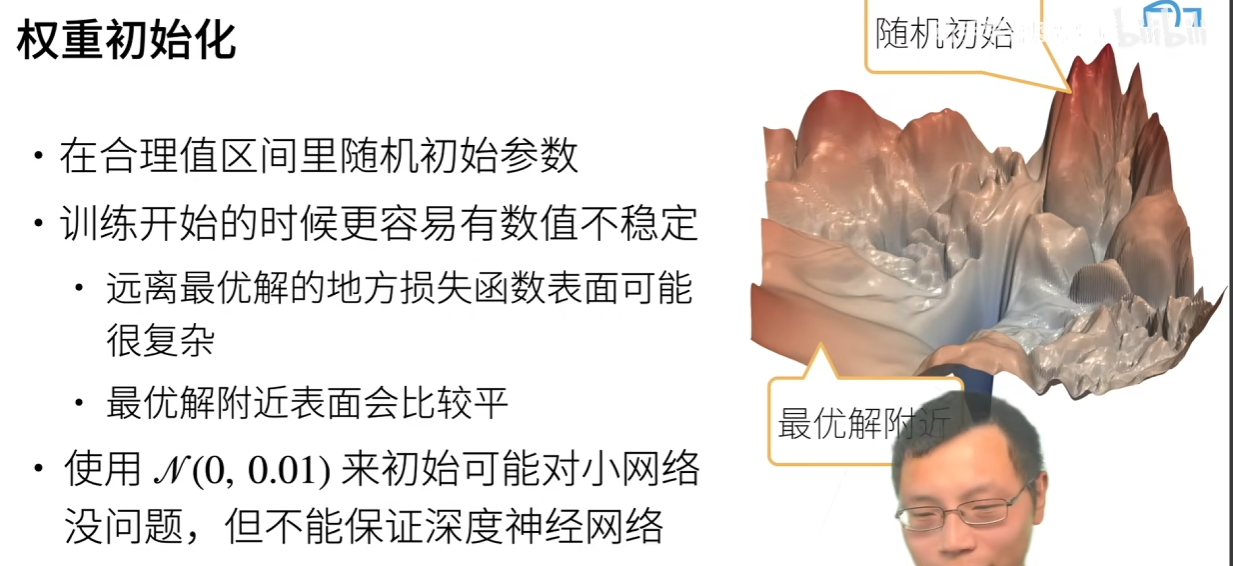

# 关于权重调整的思考

你在想：“原来权重该是多少就是多少，你凭什么改小？改了之后结果不就变了吗？不就不准了吗？” 

这个想法完全合理，但有一个关键误解——权重本来就没有“该是多少”。想清楚一件事：权重的初始值是瞎猜的！训练开始之前，我们根本不知道正确的权重是多少。

**训练前**：权重是随机的（瞎猜）
**训练中**：慢慢调整权重
**训练后**：权重才是对的

所以初始化不是在“改正确答案”，而是在决定——我瞎猜的时候，猜的范围多大合适？

## 用最简单的例子说明
### 场景：2个输入的神经元
$h = w_1 × x_1 + w_2 × x_2$

假设输入 $x_1$、$x_2$ 都在 -1 到 1 之间随机。如果权重也在 -1 到 1 之间随机：
- 每一项 $w×x$ 的结果大概在 -1 到 1 之间。
- 两项加起来，结果大概在 -2 到 2 之间。波动不算太大，还行 ✓

### 现在变成1000个输入
$h = w_1×x_1 + w_2×x_2 + ... + w_{1000}×x_{1000}$

如果权重还是 -1 到 1 之间随机：
- 每一项还是 -1 到 1。
- 但是！1000项加起来！结果大概在 -30 到 30 之间（波动巨大）。

你发现问题了吗？2个输入时，输出波动 -2 到 2；1000个输入时，输出波动 -30 到 30。输入的“内容”没变，只是数量多了，输出就炸了！

这就是问题所在：不是“改数据”，是
## 适应数据的数量

打个比方：
- 你让2个人往池子里倒水，每人倒1桶，池子水位涨2桶——没事。
- 你让1000个人往池子里倒水，每人还倒1桶，池子水位涨1000桶——溢出来了！

怎么办？让1000个人，每人只倒 $\frac{1}{1000}$ 桶。这样总量还是约等于1桶，和2个人时的效果一样稳定。

你改的不是“正确答案”，你改的是“每个人倒多少”，来保证总量稳定。

关键理解：你没有改变网络的能力。

“改小了权重，网络不就废了吗？”不会！因为——
1. **训练会把权重调到正确值**：初始化只是起跑位置，不是终点。
**大权重初始化**：起跑在悬崖边上 → 容易掉下去（爆炸）
**小权重初始化**：起跑在深坑里   → 爬不出来（消失）
**合适的初始化**：起跑在平地上   → 可以顺利跑到终点

不管你初始权重是多少，训练都会调整它。

2. **权重小，但输入多，效果是一样的**：
2个输入，每个权重 = 0.5：$0.5 × x_1 + 0.5 × x_2 ≈$ 波动范围1

1000个输入，每个权重 = 0.03：$0.03 × x_1 + 0.03 × x_2 + ... + 0.03 × x_{1000} ≈$ 波动范围也是1

虽然每个权重变小了，但加的项多了，总效果一样！网络的表达能力没有减少。

## 如果不这么做会怎样？
实际看看灾难。假设100层网络，每层1000个神经元：
### 不用Xavier（权重都在 -1 到 1）：
- **第1层输出**：波动范围 ±30
- **第2层输出**：波动范围 ±900
- **第3层输出**：波动范围 ±27000
- ...
- **第10层**：数字已经大到计算机存不下 → NaN → 训练失败

### 用Xavier（权重在很小范围内）：
- **第1层输出**：波动范围 ±1
- **第2层输出**：波动范围 ±1
- **第3层输出**：波动范围 ±1
- ...
- **第100层**：波动范围还是 ±1 → 训练正常

⭐⭐回答你的问题：
- “凭什么改权重？”因为权重本来就是随机猜的，反正都是猜，为什么不猜一个让网络能正常训练的范围？
- “改了不影响结果吗？”初始值不是最终值。 训练会把权重调到正确的地方。Xavier只是确保训练能顺利开始，而不是一开始就爆炸或消失。
- “凭什么改成 $\frac{1}{1000}$？”因为1000个东西加在一起天然会变大。每个缩小 $\frac{1}{1000}$，加起来才和原来一样稳定。这不是乱改，这是数学上唯一能保持稳定的选择。 

---

## 🟢 不用管的

| 内容                            | 原因                       |
| ------------------------------- | -------------------------- |
| 方差推导的具体数学过程          | 知道结论就行               |
| 均匀分布版Xavier的系数为什么是6 | 均匀分布方差公式，用到再查 |
| 对角矩阵乘法的细节              | 理论推导用的               |
| 泰勒展开的具体计算              | 数学工具，理解思想即可     |
| 调整后的Sigmoid公式（4σ-2）     | 实际几乎不用Sigmoid        |

---

## ⭐⭐⭐ 写代码时的模板

```python
# ❌ 以前的写法（固定方差，深网络不行）：
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

# ✅ 用ReLU时 → 配 He（Kaiming）初始化（最常用的组合）：
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)

# ✅ 用tanh时 → 配 Xavier初始化：
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
```

```python
# 激活函数选择：
nn.ReLU()    # 默认首选，最常用，配kaiming初始化
nn.Tanh()    # 也可以，配xavier初始化
# nn.Sigmoid()  # 尽量别用，除非你知道为什么要用
```

---

## 总结

> **深网络容易梯度爆炸/消失 → 用合理的初始化（ReLU配He，tanh配Xavier） → 让每层的值都保持在合理范围，训练才能顺利进行**